# Optogenetic Model Evaluation

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif'] = "Lato"
sys.path.append(os.path.dirname(os.getcwd()))

## Light Model

### 3D graphic
First we'll compare the model to figure 2A from Foutz et al. 2012.

![Foutz et al. 2012 Figure 2A](foutz12_2a.jpg)

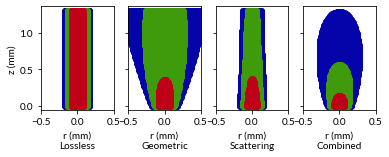

In [2]:
from matplotlib import colors
from brian2 import mm
import brian2.units.unitsafefunctions as usf

from clocsim.stimulators.opto import *

opto = OptogeneticIntervention(name='opto', opsin_model=four_state, 
        opsin_params=ChR2_four_state, light_model_params=default_blue)

x = np.linspace(-0.9, 0.9, 200)
y = np.linspace(-0.2, 1.3, 300)
x, y = np.meshgrid(x, y)
dir_uvec = np.array([[0], [1]])

coords = np.vstack([x.flatten(), y.flatten()]).T
coords = coords*mm
z = usf.dot(coords, dir_uvec)  # distance along cylinder axis
r = np.sqrt( np.sum( (coords-usf.dot(z, dir_uvec.T))**2, axis=1 ) )
r = r.reshape((-1, 1))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
ax1.set_ylabel('z (mm)')

def plot_panel(ax, T, label):
    # filter out points with <0.001 transmittance to make plotting faster
    blue_T = 0.001
    idx_to_plot = T[:,0] >= blue_T
    x_plot = x.flatten()[idx_to_plot]; y_plot = y.flatten()[idx_to_plot]
    T = T[idx_to_plot, 0]
    def plot_interval(start, stop, color):
        idxs = (T >= start) & (T < stop)
        ax.scatter(x_plot[idxs], y_plot[idxs], c=color, marker='o')
    plot_interval(.001, .01, 'xkcd:royal blue')
    plot_interval(.01, .1, 'xkcd:grass green')
    plot_interval(.1, 1, 'xkcd:scarlet')
    ax.set_aspect('equal')
    ax.set_xlim((-.5, .5)); ax.set_xlabel(f'r (mm)\n{label}')

plot_panel(ax1, opto._Foutz12_transmittance(r, z, 
        spread=False, scatter=False), 'Lossless')
plot_panel(ax2, opto._Foutz12_transmittance(r, z, scatter=False), 'Geometric')
plot_panel(ax3, opto._Foutz12_transmittance(r, z, spread=False), 'Scattering')
plot_panel(ax4, opto._Foutz12_transmittance(r, z), 'Combined')

plt.show()

Qualitatively it looks pretty close. The scattering plot is the most off, but that could be a result of differences in how the plots are generated. They are using 3D shells which could be sliced at an angle and I'm using point samples.

### Transmission-distance plot
Next we'll try to replicate figure 2B from Foutz et al. 2012. The x-axis represents distance from light to the cell body, ranging from 0 to 2 mm. Each line is for optic fibers of different radii.

![Foutz et al. 2012 Figure 2B](foutz12_2b.jpg)

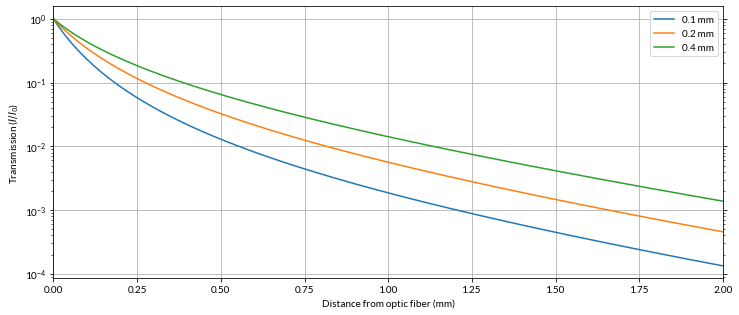

In [3]:
plt.figure(figsize=(12,5))
z = np.linspace(0, 2, 200)*mm
g = False
opto.light_model_params['R0'] = 0.05*mm
T1 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
opto.light_model_params['R0'] = 0.2*mm
T4 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
opto.light_model_params['R0'] = 0.1*mm
T2 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
plt.plot(z/mm, T1, label='0.1 mm')
plt.plot(z/mm, T2, label='0.2 mm')
plt.plot(z/mm, T4, label='0.4 mm')
plt.yscale('log')
plt.ylabel('Transmission ($I/I_0$)')
plt.xlabel('Distance from optic fiber (mm)')
plt.legend(); plt.grid(True); plt.tick_params(right=True, which='both')
plt.xlim(0, 2)
# matplotlib.rc('font', size=30)
plt.show()

## Opsin model
Now let's see that the opsin model is working as expected. This chart is the result of the ramp protocol for ChR2 from PyRhO (Evans et al., 2016)

![PyRhO ChR2 ramp protocol](pyrho_ChR2_ramp.png)

In [4]:
from brian2 import NeuronGroup, ms, StateMonitor, run, plot, Network, collect
from clocsim.coordinates import assign_coords_rect_prism
from clocsim.utilities import modify_model_with_eqs

ng = NeuronGroup(3, '''v = -70*mV : volt
        Iopto: ampere''')
assign_coords_rect_prism(ng, 'grid', (0,0), (0,0), (0,0), xyz_grid_shape=(3, 1, 1))
opto.connect_to_neurons(ng)

pulse_width = 250*ms

# converting from photon flux to irradiance at point (Irr) to fiber tip irradiance (Irr0)
# phi [1e18, 1e17, 1e16] * Ephoton / T
# opto.opto_syn.run_regularly('''pulse = t < pulse_width
#         Irr0_peak = 1e18/10**i /second/meter2 * Ephoton / T
#         Irr0 = pulse * Irr0_peak * (t/pulse_width)
# ''')

# phi_mon = StateMonitor(opto.opto_syn, 'phi', record=True)
Iopto_mon = StateMonitor(ng, 'Iopto', record=True)

net = Network(collect())
net.add(opto.opto_syn)
net.run(0.1*ms)
# run(pulse_width+50*ms)